In [2]:
import pandas as pd
from sqlalchemy import create_engine

engine = create_engine("sqlite:///../movielens.db")

movies_df = pd.read_sql("SELECT * FROM movies", con=engine)
ratings_df = pd.read_sql("SELECT * FROM ratings", con=engine)
users_df = pd.read_sql("SELECT * FROM users", con=engine)

# See first rows of each DataFrame
print(movies_df.head())
print(ratings_df.head())
print(users_df.head())


   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   id  userId  movieId  rating  timestamp
0   1       1        1     4.0  964982703
1   2       1        3     4.0  964981247
2   3       1        6     4.0  964982224
3   4       1       47     5.0  964983815
4   5       1       50     5.0  964982931
   userId
0       1
1       2
2       3
3       4
4       5


In [4]:
print(movies_df.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [5]:
print(ratings_df.head())

   id  userId  movieId  rating  timestamp
0   1       1        1     4.0  964982703
1   2       1        3     4.0  964981247
2   3       1        6     4.0  964982224
3   4       1       47     5.0  964983815
4   5       1       50     5.0  964982931


In [6]:
print(users_df.head())

   userId
0       1
1       2
2       3
3       4
4       5


In [8]:
# Calculate average ratings and count of ratings per movie
movie_stats = ratings_df.groupby("movieId").agg(
    avg_rating=("rating", "mean"),
    rating_count=("rating", "count")
).reset_index()

# Merge with movies DataFrame to get movie titles
movie_stats = movie_stats.merge(movies_df, left_on="movieId", right_on="movieId")

# Sort top 10 movies with high rating count
top_movies = movie_stats[movie_stats["rating_count"] > 100].sort_values(
    by="avg_rating", ascending=False
).head(10)

top_movies[["title", "avg_rating", "rating_count"]]

,title,avg_rating,rating_count
277,"Shawshank Redemption, The (1994)",4.429022,317
659,"Godfather, The (1972)",4.289062,192
2224,Fight Club (1999),4.272936,218
921,"Godfather: Part II, The (1974)",4.259690,129
6298,"Departed, The (2006)",4.252336,107
913,Goodfellas (1990),4.250000,126
6693,"Dark Knight, The (2008)",4.238255,149
46,"Usual Suspects, The (1995)",4.237745,204
898,"Princess Bride, The (1987)",4.232394,142
224,Star Wars: Episode IV - A New Hope (1977),4.231076,251


In [ ]:
# Find most active users
top_users = ratings_df["userId"].value_counts().head(10)
top_users

userId
414    2698
599    2478
474    2108
448    1864
274    1346
610    1302
68     1260
380    1218
606    1115
288    1055
Name: count, dtype: int64

In [12]:
# Explode genres for analysis
movies_exploded = movies_df.copy()
movies_exploded["genre"] = movies_exploded["genres"].str.split("|")
movies_exploded = movies_exploded.explode("genre")

# Calculate average ratings per genre
genre_ratings = movies_exploded.merge(movie_stats, left_on="movieId", right_on="movieId")
genre_grouped = genre_ratings.groupby("genre")["avg_rating"].mean().sort_values(ascending=False)
genre_grouped

genre
Documentary           3.781682
Film-Noir             3.670471
War                   3.571655
Animation             3.497119
Drama                 3.420905
Western               3.383389
(no genres listed)    3.371148
Romance               3.364870
Mystery               3.330364
IMAX                  3.311996
Crime                 3.301844
Musical               3.296371
Fantasy               3.218843
Adventure             3.215230
Comedy                3.181716
Thriller              3.156116
Children              3.107690
Sci-Fi                3.102637
Action                3.094498
Horror                2.918965
Name: avg_rating, dtype: float64

C:\Users\user\AppData\Local\Temp\ipykernel_4752\2447716291.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=ratings_df, x="rating", palette="viridis")


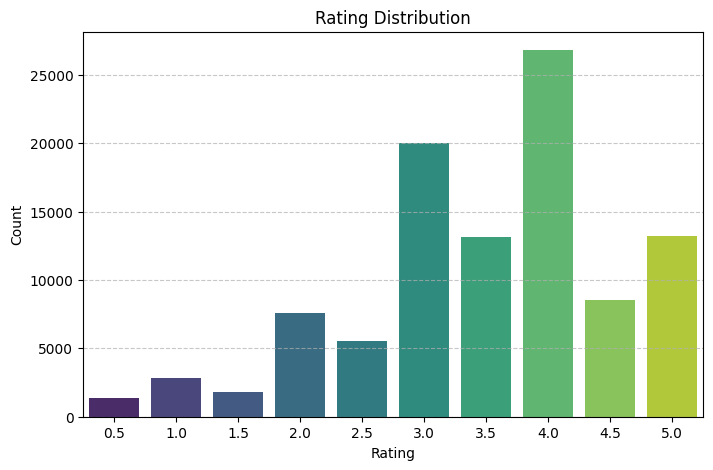

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot rating distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=ratings_df, x="rating", palette="viridis")
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [14]:
import re

# Extract year from title
movies_df["year"] = movies_df["title"].str.extract(r"\((\d{4})\)")
movies_df["year"] = pd.to_numeric(movies_df["year"], errors="coerce")

# Drop rows with NaN years and convert to int
movies_df = movies_df.dropna(subset=["year"])
movies_df["year"] = movies_df["year"].astype(int)


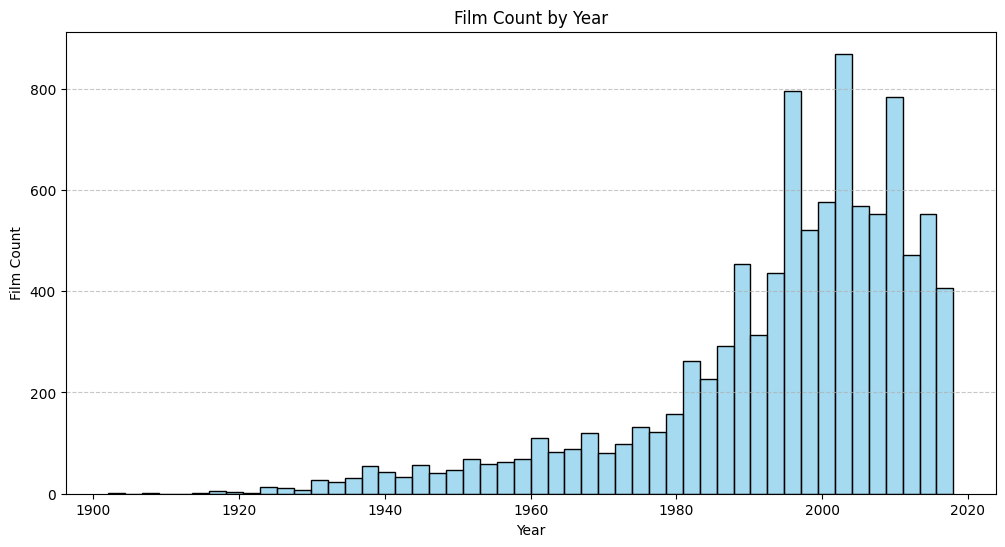

In [ ]:
# Plot film count by year
plt.figure(figsize=(12, 6))
sns.histplot(data=movies_df, x="year", bins=50, kde=False, color="skyblue")
plt.title("Film Count by Year")
plt.xlabel("Year")
plt.ylabel("Film Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

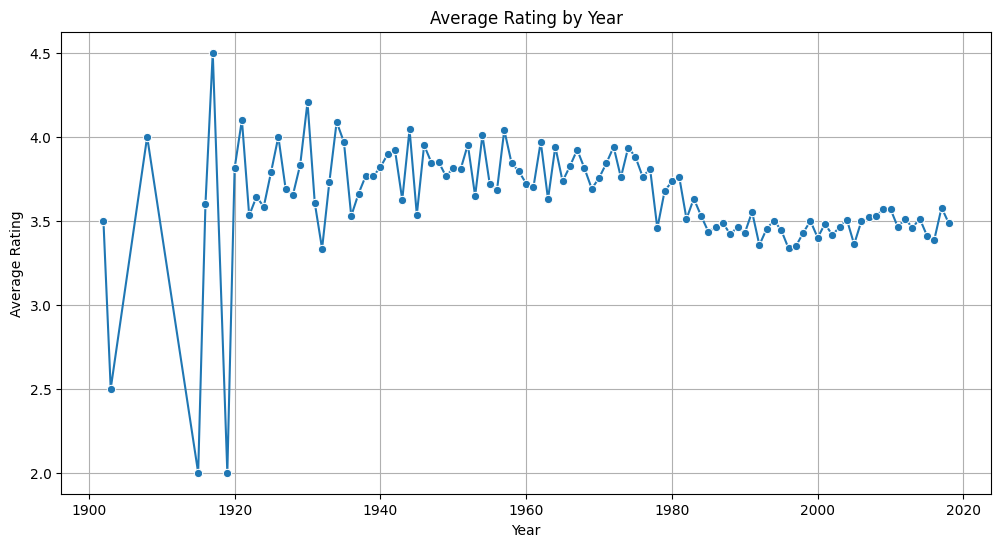

In [ ]:
# Merge ratings with movies to get year information
ratings_with_year = ratings_df.merge(movies_df[["movieId", "year"]], left_on="movieId", right_on="movieId")

# Calculate average rating per year
yearly_avg = ratings_with_year.groupby("year")["rating"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_avg, x="year", y="rating", marker="o")
plt.title("Average Film Rating by Year")
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.grid(True)
plt.show()